<h1>Bird Network</h1>

Let's start with one year of data; our 2019 data; we're going to have all of the weather data and bird data
Our input (for the one-year run) will be just weather and number of birds
Except that we also want the weather data for the day of
Let's first figure out how to do it and then figure out how to get the data in the form that will let us do it

In [1]:
# code time
# Let's try to get our data into this form now
# We want a bunch of rows, each of which is like a bunch of arrays...

# current issue: how to get array inputs instead of number inputs for each time step

In [2]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a white background
set_style("whitegrid")

## Import all the keras stuff we'll need
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

In [3]:
model = models.Sequential()

# Then the SimpleRNN layer
# the first input should be the same size as the input layer, i.e. 32
# return_sequences determines if the network should return the hidden state value for 
# each hidden layer h1, h2, ..., hT
# Since we only want the last one, hT, we set it equal to False
# If we were building a network with multiple SimpleRNN layers,
# you'd set this to True
model.add(layers.SimpleRNN(30, input_shape=(30,6), return_sequences=False))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.summary()
model.compile(optimizer='rmsprop',
              loss="mse",
                 metrics=['mse'])

/opt/homebrew/Caskroom/miniforge/base/envs/myname/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30)             │         1,110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,711 (10.59 KB)

 Trainable params: 2,711 (10.59 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Now let's get our data in here
import datetime

def diff(row):
    return (datetime.date(int(row["YEAR"]),int(row["MONTH"]),int(row["DAY"])) - datetime.date(2017,1,1)).days

def diffmod(row):
    return (datetime.date(int(row["YEAR"]),int(row["MONTH"]),int(row["DAY"])) - datetime.date(int(row["YEAR"]),1,1)).days

df = pd.read_csv("Data/AllSpecYear.csv")
df = df[df["LATITUDE"]==36]
df = df[df["LONGITUDE"]==-86]
df["T"] = df.apply(diff,axis=1)
df["DOY"] = df.apply(diffmod,axis=1)
df = df.sort_values("T")[["OBSERVATION COUNT","PRCP","SNOW","TMAX","DOY","SPECIES","T"]]
df = df[["OBSERVATION COUNT","PRCP","SNOW","TMAX","DOY","SPECIES","T"]]
df=df[df["SPECIES"]==0]
array = df.drop("T",axis=1).to_numpy()
Xarray = np.empty((int((len(array)-30)/15+1),30,6))
Yarray = np.array([])
for i in range(len(array)-30):
    if i%15==0:
        for j in range(30):
            Xarray[int(i/15)][j] = array[i+j]
        Yarray = np.append(Yarray,[array[i+30][0]])
print(Xarray)
print(Yarray)
# 30 day guys...

[[[1.66666667e+00 7.70740741e+01 0.00000000e+00 8.87500000e+01
   0.00000000e+00 0.00000000e+00]
  [1.50000000e+00 1.89310345e+01 0.00000000e+00 1.39111111e+02
   1.00000000e+00 0.00000000e+00]
  [5.00000000e+00 9.31290323e+01 0.00000000e+00 1.71444444e+02
   2.00000000e+00 0.00000000e+00]
  ...
  [2.00000000e+00 0.00000000e+00 0.00000000e+00 1.62000000e+02
   4.10000000e+01 0.00000000e+00]
  [2.00000000e+00 2.21428571e+00 0.00000000e+00 1.96250000e+02
   4.20000000e+01 0.00000000e+00]
  [1.00000000e+00 2.85714286e-01 0.00000000e+00 1.88300000e+02
   4.30000000e+01 0.00000000e+00]]

 [[1.00000000e+00 2.97242424e+02 0.00000000e+00 1.57300000e+02
   1.90000000e+01 0.00000000e+00]
  [4.00000000e+00 3.82142857e+00 0.00000000e+00 1.81750000e+02
   2.00000000e+01 0.00000000e+00]
  [1.00000000e+00 1.52000000e+02 0.00000000e+00 1.68100000e+02
   2.20000000e+01 0.00000000e+00]
  ...
  [6.00000000e+00 2.55172414e+00 0.00000000e+00 9.82222222e+01
   7.10000000e+01 0.00000000e+00]
  [5.00000000e+0

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xarray, Yarray,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2)
print(len(y_train))
X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                           test_size=.2,
                                                           shuffle=True,
                                                           random_state=440)

87


In [6]:
epochs = 20

history = model.fit(X_train_train, y_train_train,
                    epochs = epochs,
                    batch_size=128,
                    validation_data=(X_val,y_val))

## Note training this model can take a while

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 21.6749 - mse: 21.6749 - val_loss: 23.4934 - val_mse: 23.4934
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 19.2679 - mse: 19.2679 - val_loss: 22.2759 - val_mse: 22.2759
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 17.8169 - mse: 17.8169 - val_loss: 21.4974 - val_mse: 21.4974
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.8067 - mse: 16.8067 - val_loss: 20.9193 - val_mse: 20.9193
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.0347 - mse: 16.0347 - val_loss: 20.4795 - val_mse: 20.4795
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15.4153 - mse: 15.4153 - val_loss: 20.1553 - val_mse: 20.1553
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 14.9089 - mse: 14.9089 - val_loss: 19.8966 - val_mse: 19.8966
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 14.4711 - mse: 14.4711 - val_loss: 19.6945 - val_mse: 19.6945
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/ste

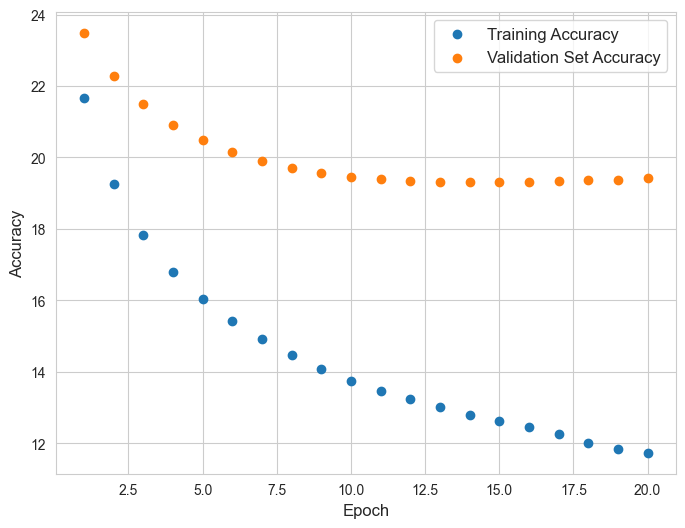

In [7]:
history_dict = history.history
## Plotting the training and validation accuracy
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['mse'], label = "Training Accuracy")
plt.scatter(range(1,epochs+1), history_dict['val_mse'], label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

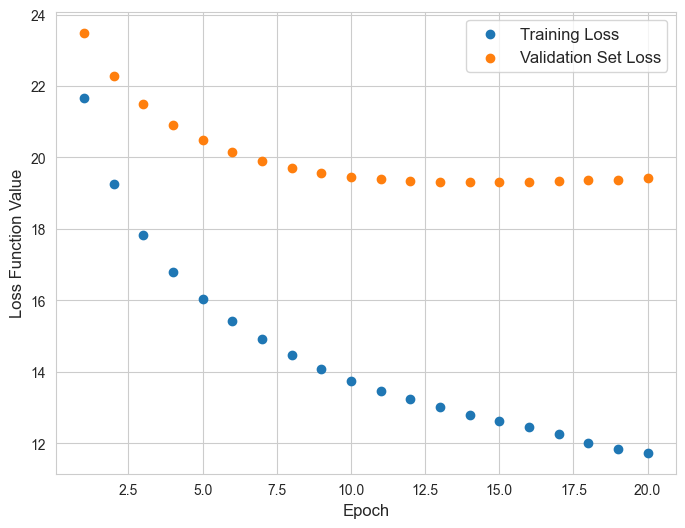

In [8]:
## Plotting the training and validation loss
plt.figure(figsize = (8,6))

plt.scatter(range(1,epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,epochs+1), history_dict['val_loss'], label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [9]:
# from sklearn.metrics import mean_squared_error

# ## print the test set performance
# print("Test set MSE:", 
#       np.round(mean_squared_error(y_train, model.predict(X_train.reshape(-1,1))),2))


model.evaluate(X_test,y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.2949 - mse: 10.2949


[10.294942855834961, 10.294942855834961]

In [10]:
print(model.predict(X_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[3.3010478]
 [3.3205566]
 [3.3575273]
 [4.6788616]
 [2.4685829]
 [3.323974 ]
 [3.3224516]
 [1.2423468]
 [1.6155384]
 [3.3574386]
 [3.0920663]
 [3.322908 ]
 [3.1572602]
 [2.2674215]
 [3.8789299]
 [3.8789167]
 [4.1739697]
 [3.3567865]]
